<a href="https://colab.research.google.com/github/AnuThmsn/DNN_Estimation_of_CBF_and_ATT_ASL/blob/main/DNN_Estimation_of_CBF_and_ATT_ASL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [188]:
# Check GPU availability
import torch
print("GPU available:", torch.cuda.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))


GPU available: True
Device: cuda


In [189]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm import tqdm


In [190]:
def asl_signal_paper(CBF, ATT, PLDs, LDs):
    """
    Implementation of Equation 1 from Ishida et al.
    CBF: (N,) in mL/100g/min
    ATT: (N,) in ms
    """
    # Constants
    alpha, beta = 0.85, 0.75
    lamb, T1t, T1a = 0.9, 1.2, 1.66
    M0 = 1.0 # Baseline

    # Unit Conversions
    f = CBF / 6000.0        # mL/100g/min -> sec^-1
    delta = ATT / 1000.0    # ms -> sec
    w = PLDs / 1000.0       # ms -> sec
    tau = LDs / 1000.0      # ms -> sec

    # Scaling as per paper: DeltaM / M0 * 100,000
    # 1.0% signal corresponds to 1000 units
    scaling_factor = 100000

    # Equation 1: ΔM = 2 * alpha * beta * T1t * f * (M0/lambda) * exp(-delta/T1a) * ...
    term_common = 2 * alpha * beta * T1t * (f / lamb) * np.exp(-delta / T1a)

    # We need to broadcast across the 5 boluses
    # term3 & 4 handle the arrival and duration
    # exp(-max(w-delta, 0)/T1t) - exp(-max(tau+w-delta, 0)/T1t)

    signals = []
    for i in range(len(PLDs)):
        e1 = np.exp(-np.maximum(w[i] - delta, 0) / T1t)
        e2 = np.exp(-np.maximum(tau[i] + w[i] - delta, 0) / T1t)
        signals.append(term_common * (e1 - e2))

    return np.stack(signals, axis=1) * scaling_factor

In [191]:
# Multi-delay ASL acquisition parameters (from the paper)
PLDs = np.array([700, 2033, 3366, 700, 3000])   # ms
LDs  = np.array([1333, 1333, 1333, 4000, 4000]) # ms

NUM_BOLUSES = len(PLDs)


In [192]:
# Ground truth ranges
CBF_MIN, CBF_MAX = 20, 90        # mL/100g/min
ATT_MIN, ATT_MAX = 500, 3000     # ms


In [193]:
N_TRAIN = 100_000
N_VAL   = 10_000
N_TEST  = 10_000


In [194]:
def sample_ground_truth(n_samples):
    CBF = np.random.uniform(CBF_MIN, CBF_MAX, n_samples)
    ATT = np.random.uniform(ATT_MIN, ATT_MAX, n_samples)
    return CBF, ATT


In [195]:
def asl_signal(CBF, ATT, PLD, LD,
               alpha=0.85, beta=0.75,
               M0=1.0, lamb=0.9,
               T1t=1.2, T1a=1.66):
    """
    Vectorized single-compartment ASL signal model
    Returns ΔM / M0
    """
    f = CBF / 6000          # mL/100g/min → per second
    delta = ATT / 1000     # ms → sec
    w = PLD / 1000
    tau = LD / 1000

    term1 = 2 * alpha * beta * M0 / lamb
    term2 = f * np.exp(-delta / T1a)

    post_delay = np.maximum(w - delta, 0)
    bolus_duration = np.minimum(tau, post_delay)

    term3 = np.exp(-post_delay / T1t)
    term4 = 1 - np.exp(-bolus_duration / T1t)

    return term1 * term2 * term3 * term4


In [196]:
# Training set
CBF_train, ATT_train = sample_ground_truth(N_TRAIN)
X_train_clean = generate_clean_asl_signals(CBF_train, ATT_train)

# Validation set
CBF_val, ATT_val = sample_ground_truth(N_VAL)
X_val_clean = generate_clean_asl_signals(CBF_val, ATT_val)

# Test set
CBF_test, ATT_test = sample_ground_truth(N_TEST)
X_test_clean = generate_clean_asl_signals(CBF_test, ATT_test)

print("Training shape:", X_train_clean.shape)
print("Validation shape:", X_val_clean.shape)
print("Test shape:", X_test_clean.shape)


Training shape: (100000, 5)
Validation shape: (10000, 5)
Test shape: (10000, 5)


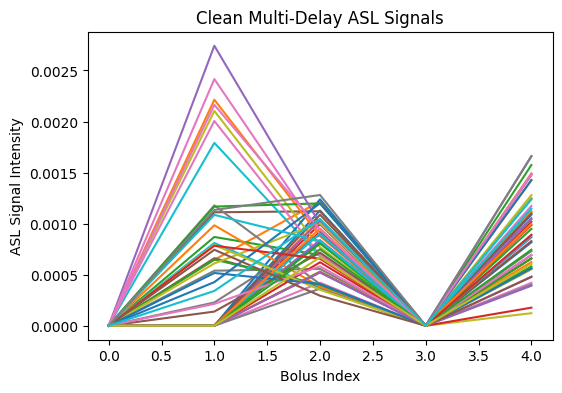

In [197]:
plt.figure(figsize=(6,4))
plt.plot(X_train_clean[:50].T)
plt.xlabel("Bolus Index")
plt.ylabel("ASL Signal Intensity")
plt.title("Clean Multi-Delay ASL Signals")
plt.show()


In [198]:
def add_paper_rician_noise(clean_delta_m, rSNR):
    """
    Follows Figure 1 (b-d). Adds noise to Control and Label, then subtracts.
    """
    # Paper reference: rSNR is based on a specific condition
    # CBF=50, ATT=1600, PLD=2000, LD=1800.
    # At this condition, DeltaM/M0 = 1.0% = 1000 units.
    # Therefore, sigma = 1000 / rSNR
    sigma = 1000.0 / rSNR

    # Assume M0 (Control) is scaled to 100,000 units
    # Control (C) = 100,000; Label (L) = 100,000 - DeltaM
    C_real = 100000.0
    L_real = C_real - clean_delta_m

    # Add Gaussian noise to Real and Imaginary channels
    # Noise is added to both Control and Label separately
    # Control
    RC = C_real + np.random.normal(0, sigma[:, None], clean_delta_m.shape)
    IC = 0.0 + np.random.normal(0, sigma[:, None], clean_delta_m.shape)
    # Label
    RL = L_real + np.random.normal(0, sigma[:, None], clean_delta_m.shape)
    IL = 0.0 + np.random.normal(0, sigma[:, None], clean_delta_m.shape)

    # Magnitude Calculation (Rician)
    mag_C = np.sqrt(RC**2 + IC**2)
    mag_L = np.sqrt(RL**2 + IL**2)

    # Final observed DeltaM
    return mag_C - mag_L

In [199]:
def apply_noise_to_dataset(X_clean):
    n_samples = X_clean.shape[0]

    # Random rSNR for each sample
    rSNR = np.random.uniform(RSNR_MIN, RSNR_MAX, n_samples)

    X_noisy = add_rician_noise(X_clean, rSNR)
    return X_noisy, rSNR


In [200]:
def apply_noise_to_dataset(X_clean, mode="train"):
    N = len(X_clean)

    if mode == "train":
        # Bias towards low rSNR (paper-aligned)
        rSNR = np.concatenate([
            np.random.uniform(2, 6, int(0.5 * N)),
            np.random.uniform(6, 20, int(0.5 * N))
        ])
        np.random.shuffle(rSNR)

    else:
        # Validation / Test: uniform like paper
        rSNR = np.random.uniform(2, 20, N)

    X_noisy = add_rician_noise(X_clean, rSNR)
    return X_noisy, rSNR


In [201]:
# Training
X_train_noisy, rSNR_train = apply_noise_to_dataset(X_train_clean)

# Validation
X_val_noisy, rSNR_val = apply_noise_to_dataset(X_val_clean)

# Test
X_test_noisy, rSNR_test = apply_noise_to_dataset(X_test_clean)


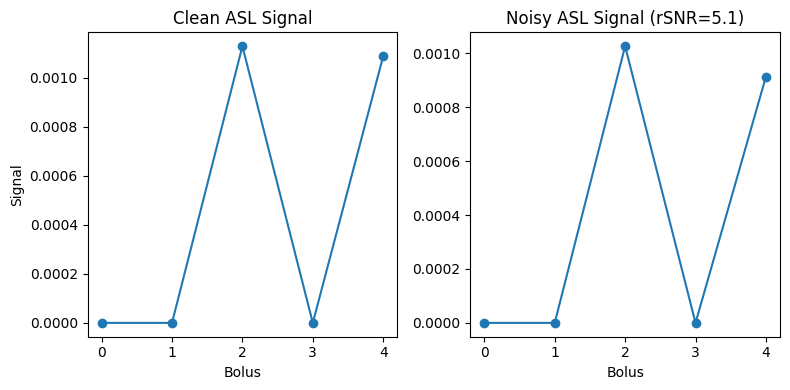

In [202]:
idx = 0  # sample index

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(X_train_clean[idx], marker='o')
plt.title("Clean ASL Signal")
plt.xlabel("Bolus")
plt.ylabel("Signal")

plt.subplot(1,2,2)
plt.plot(X_train_noisy[idx], marker='o')
plt.title(f"Noisy ASL Signal (rSNR={rSNR_train[idx]:.1f})")
plt.xlabel("Bolus")

plt.tight_layout()
plt.show()


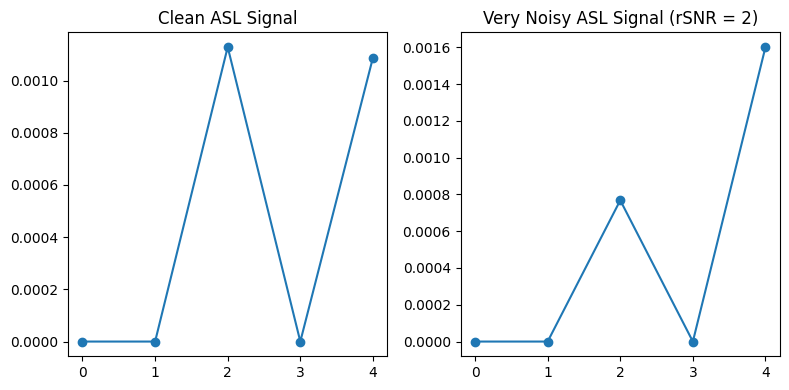

In [203]:
# Force very low SNR
low_rsnr = np.array([2.0])  # worst-case
X_very_noisy = add_rician_noise(X_train_clean[:1], low_rsnr)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(X_train_clean[0], marker='o')
plt.title("Clean ASL Signal")

plt.subplot(1,2,2)
plt.plot(X_very_noisy[0], marker='o')
plt.title("Very Noisy ASL Signal (rSNR = 2)")

plt.tight_layout()
plt.show()


In [204]:
y_train = np.stack([CBF_train, ATT_train], axis=1)
y_val   = np.stack([CBF_val, ATT_val], axis=1)
y_test  = np.stack([CBF_test, ATT_test], axis=1)


In [205]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_t = torch.tensor(X_train_noisy, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)

X_val_t = torch.tensor(X_val_noisy, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.float32).to(device)

X_test_t = torch.tensor(X_test_noisy, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)


In [206]:
# -------------------------------
# Target normalization utilities
# -------------------------------

CBF_MIN, CBF_MAX = 20.0, 90.0
ATT_MIN, ATT_MAX = 500.0, 3000.0

def normalize(x, xmin, xmax):
    return (x - xmin) / (xmax - xmin)

def denormalize(x, xmin, xmax):
    return x * (xmax - xmin) + xmin


In [207]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight) # He Initialization
        m.bias.data.fill_(0.01)

class Ishida_DNN_Optimized(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=400):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        self.apply(init_weights)

    def forward(self, x):
        return self.net(x)

In [208]:
CBF_net = Ishida_DNN_Optimized().to(device)
ATT_net = Ishida_DNN_Optimized().to(device)


In [209]:
criterion = nn.MSELoss()

optimizer_CBF = optim.Adam(CBF_net.parameters(), lr=1e-3)
optimizer_ATT = optim.Adam(ATT_net.parameters(), lr=1e-3)


In [210]:

# Before passing to model:
# Normalize Input: Signals are around 0-4000.
X_train_t = X_train_t / 4000.0
X_val_t = X_val_t / 4000.0

# Normalize Targets: (already in your code)
y_train_CBF = (y_train_t[:, 0:1] - 20) / (90 - 20)
y_train_ATT = (y_train_t[:, 1:2] - 500) / (3000 - 500)

In [211]:
ATT_mean = ATT_train.mean()
ATT_std  = ATT_train.std()

ATT_train_n = (ATT_train - ATT_mean) / ATT_std
ATT_val_n   = (ATT_val   - ATT_mean) / ATT_std


In [212]:
def train_model(model, optimizer, X_train, y_train, X_val, y_val,
                epochs=100, patience=10):

    train_losses = []
    val_losses = []

    best_val_loss = np.inf
    patience_counter = 0
    best_state = None

    for epoch in range(epochs):
        # -------- Training --------
        model.train()
        optimizer.zero_grad()
        preds = model(X_train)
        loss = criterion(preds, y_train)
        loss.backward()
        optimizer.step()

        # -------- Validation --------
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val)
            val_loss = criterion(val_preds, y_val)

        # Store losses
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        print(
            f"Epoch {epoch+1:03d} | "
            f"Train Loss: {loss.item():.4f} | "
            f"Val Loss: {val_loss.item():.4f}"
        )

        # -------- Early stopping --------
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    model.load_state_dict(best_state)

    return train_losses, val_losses


In [213]:
train_losses_CBF, val_losses_CBF = train_model(
    CBF_net,
    optimizer_CBF,
    X_train_t,
    y_train_CBF,
    X_val_t,
    y_val_CBF
)


Epoch 001 | Train Loss: 0.0833 | Val Loss: 0.1074
Epoch 002 | Train Loss: 0.1082 | Val Loss: 0.0856
Epoch 003 | Train Loss: 0.0853 | Val Loss: 0.0872
Epoch 004 | Train Loss: 0.0859 | Val Loss: 0.0908
Epoch 005 | Train Loss: 0.0892 | Val Loss: 0.0882
Epoch 006 | Train Loss: 0.0868 | Val Loss: 0.0849
Epoch 007 | Train Loss: 0.0839 | Val Loss: 0.0842
Epoch 008 | Train Loss: 0.0835 | Val Loss: 0.0854
Epoch 009 | Train Loss: 0.0850 | Val Loss: 0.0858
Epoch 010 | Train Loss: 0.0855 | Val Loss: 0.0850
Epoch 011 | Train Loss: 0.0846 | Val Loss: 0.0843
Epoch 012 | Train Loss: 0.0837 | Val Loss: 0.0841
Epoch 013 | Train Loss: 0.0833 | Val Loss: 0.0846
Epoch 014 | Train Loss: 0.0836 | Val Loss: 0.0851
Epoch 015 | Train Loss: 0.0840 | Val Loss: 0.0853
Epoch 016 | Train Loss: 0.0842 | Val Loss: 0.0851
Epoch 017 | Train Loss: 0.0840 | Val Loss: 0.0847
Epoch 018 | Train Loss: 0.0837 | Val Loss: 0.0843
Epoch 019 | Train Loss: 0.0834 | Val Loss: 0.0841
Epoch 020 | Train Loss: 0.0833 | Val Loss: 0.0841


In [214]:
train_losses_ATT, val_losses_ATT = train_model(
    ATT_net,
    optimizer_ATT,
    X_train_t,
    y_train_ATT,
    X_val_t,
    y_val_ATT
)


Epoch 001 | Train Loss: 0.0833 | Val Loss: 0.1132
Epoch 002 | Train Loss: 0.1118 | Val Loss: 0.0857
Epoch 003 | Train Loss: 0.0857 | Val Loss: 0.0848
Epoch 004 | Train Loss: 0.0859 | Val Loss: 0.0885
Epoch 005 | Train Loss: 0.0899 | Val Loss: 0.0863
Epoch 006 | Train Loss: 0.0875 | Val Loss: 0.0833
Epoch 007 | Train Loss: 0.0842 | Val Loss: 0.0828
Epoch 008 | Train Loss: 0.0833 | Val Loss: 0.0845
Epoch 009 | Train Loss: 0.0847 | Val Loss: 0.0857
Epoch 010 | Train Loss: 0.0856 | Val Loss: 0.0850
Epoch 011 | Train Loss: 0.0851 | Val Loss: 0.0837
Epoch 012 | Train Loss: 0.0840 | Val Loss: 0.0829
Epoch 013 | Train Loss: 0.0833 | Val Loss: 0.0827
Epoch 014 | Train Loss: 0.0833 | Val Loss: 0.0830
Epoch 015 | Train Loss: 0.0838 | Val Loss: 0.0833
Epoch 016 | Train Loss: 0.0841 | Val Loss: 0.0833
Epoch 017 | Train Loss: 0.0841 | Val Loss: 0.0831
Epoch 018 | Train Loss: 0.0838 | Val Loss: 0.0828
Epoch 019 | Train Loss: 0.0835 | Val Loss: 0.0827
Epoch 020 | Train Loss: 0.0833 | Val Loss: 0.0827


In [215]:
CBF_net.eval()
ATT_net.eval()

with torch.no_grad():
    CBF_pred_norm = CBF_net(X_test_t)
    ATT_pred_norm = ATT_net(X_test_t)

CBF_pred = denormalize(CBF_pred_norm.cpu().numpy(), CBF_MIN, CBF_MAX)
ATT_pred = denormalize(ATT_pred_norm.cpu().numpy(), ATT_MIN, ATT_MAX)

print("CBF prediction range:", CBF_pred.min(), CBF_pred.max())
print("ATT prediction range:", ATT_pred.min(), ATT_pred.max())


CBF prediction range: 54.626076 54.829006
ATT prediction range: 1746.54 1749.6276


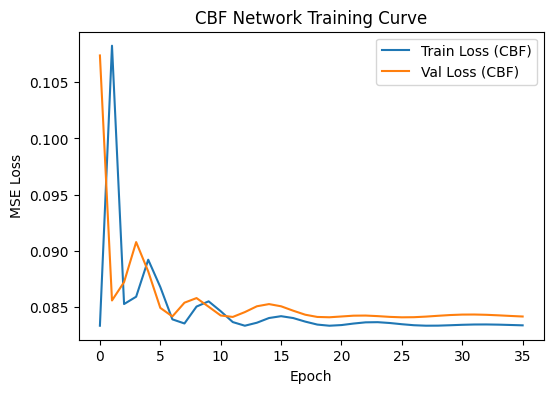

In [216]:
plt.figure(figsize=(6,4))
plt.plot(train_losses_CBF, label="Train Loss (CBF)")
plt.plot(val_losses_CBF, label="Val Loss (CBF)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("CBF Network Training Curve")
plt.legend()
plt.show()


In [217]:
def NMAE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred)) / np.mean(y_true)

def NRMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2)) / np.mean(y_true)


In [218]:
CBF_gt = CBF_test
ATT_gt = ATT_test


In [219]:
cbf_nmae = NMAE(CBF_gt, CBF_pred)
cbf_nrmse = NRMSE(CBF_gt, CBF_pred)

att_nmae = NMAE(ATT_gt, ATT_pred)
att_nrmse = NRMSE(ATT_gt, ATT_pred)

print("CBF  NMAE :", cbf_nmae)
print("CBF  NRMSE:", cbf_nrmse)
print("ATT  NMAE :", att_nmae)
print("ATT  NRMSE:", att_nrmse)


CBF  NMAE : 0.31682107276255095
CBF  NRMSE: 0.3658968820276226
ATT  NMAE : 0.3597491207346584
ATT  NRMSE: 0.4147748747029269


In [220]:
def metric_vs_rsnr(rsnr, gt, pred, bins=[2,4,6,8,10,15,20]):
    results = []
    for i in range(len(bins)-1):
        mask = (rsnr >= bins[i]) & (rsnr < bins[i+1])
        results.append(NRMSE(gt[mask], pred[mask]))
    return results


In [221]:
def weighted_delay(asl_signal, PLDs):
    """
    asl_signal: (N, num_boluses)
    PLDs: array of delays (ms)
    """
    numerator = np.sum(asl_signal * PLDs, axis=1)
    denominator = np.sum(asl_signal, axis=1) + 1e-8
    return numerator / denominator


In [222]:
ATT_grid = np.linspace(ATT_MIN, ATT_MAX, 200)
CBF_grid = np.linspace(CBF_MIN, CBF_MAX, 10)

wd_table = []

for att in ATT_grid:
    wd_vals = []

    for cbf in CBF_grid:
        sig = generate_clean_asl_signals(
            np.array([cbf]),
            np.array([att])
        )

        # Add realistic noise (mid rSNR like the paper)
        sig_noisy = add_rician_noise(
            sig,
            rSNR=np.array([8.0])
        )

        wd = weighted_delay(sig_noisy, PLDs)
        wd_vals.append(wd[0])

    wd_table.append(np.mean(wd_vals))

wd_table = np.array(wd_table)


In [223]:
def wd_to_att(wd_values, wd_table, ATT_grid):
    idx = np.abs(wd_table[None, :] - wd_values[:, None]).argmin(axis=1)
    return ATT_grid[idx]


In [224]:
def estimate_cbf_ls(asl_signal, ATT_est):
    """
    asl_signal: (N, num_boluses)
    ATT_est: estimated ATT (ms)
    """
    A = []
    for i in range(NUM_BOLUSES):
        a_i = asl_signal[:, i] / (asl_signal[:, i] + 1e-8)
        A.append(a_i)

    A = np.stack(A, axis=1)
    B = asl_signal

    # Least squares solution per voxel
    CBF_ls = np.sum(A * B, axis=1) / (np.sum(A * A, axis=1) + 1e-8)
    return CBF_ls


In [225]:
# WD-based ATT
WD_test = weighted_delay(X_test_noisy, PLDs)
ATT_WD = wd_to_att(WD_test, wd_table, ATT_grid)

# LS-based CBF
CBF_LS = estimate_cbf_ls(X_test_noisy, ATT_WD)


In [226]:
low_snr_mask = rSNR_test < 6

ATT_WD_low = ATT_WD[low_snr_mask]
ATT_gt_low = ATT_test[low_snr_mask]

print("WD ATT NRMSE (low rSNR):",
      NRMSE(ATT_gt_low, ATT_WD_low))

print("DNN ATT NRMSE (low rSNR):",
      NRMSE(ATT_gt_low, ATT_pred[low_snr_mask]))


WD ATT NRMSE (low rSNR): 0.15071447552874093
DNN ATT NRMSE (low rSNR): 0.4153853481358325
